## University of Washington: Machine Learning and Statistics 

# Lecture 2:  Regression (basis functions, regularization, cross-validation)

Andrew Connolly and Stephen Portillo

##### Resources for this notebook include:
- [Textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 8. 
- [astroML website](https://www.astroml.org/index.html)


This notebook is developed based on material from A. Connolly, Z. Ivezic, M. Juric, S. Portillo, G. Richards, B. Sipocz, J. VanderPlas, D. Hogg, and many others.

The notebook and assoociated material are available from [github](https://github.com/uw-astro/astr-598a-win22).

In [1]:
pip install corner

<a id='toc'></a>

## This notebook includes:

[Linear Basis Function Regression](#basis) 


[Regularization](#regularization) 


[Cross Validation](#cross-validation) 


[Non-linear Regression with MCMC](#mcmc) 

## Linear Basis Function Regression <a id='basis'></a>
[Go to top](#toc)

We have seen how to implement linear regression and by extension polynomial regression. We don't have to use only polynomials ($x$, $x^2$, $x^3$, etc) - we can use any function f(x)
and still have a linear problem (in unknown coefficients, $a_i$), e.g.

$$  y(x) = \sum_i^N a_i \, f_i(x) $$

### Example: 

Let's express a complicated $y(x)$, such a cosmmological distance-redshift relation, as sum of 
Gaussian functions: $ f_i(x) = N(x|\mu_i, \sigma)$, where $\mu_i$ are defined on a grid and $\sigma$ is constant and chosen depending on the intrinsic problem resolution.

### NOTE: We  suppress warnings for the packages (this is not recommended) 

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Using astroML regression to fit a set of basis functions

Text(0.5, 0, '$z$')

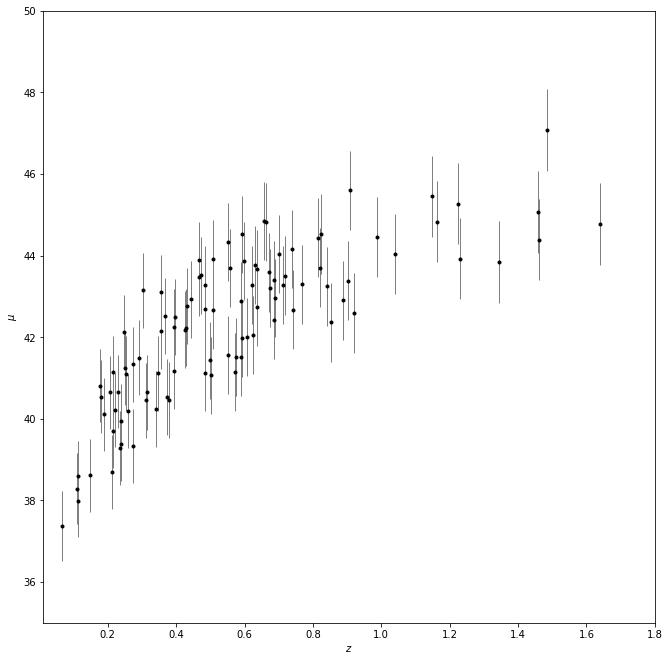

In [3]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

#------------------------------------------------------------
# Generate data
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

# Plot data and fit
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    hspace=0.05, wspace=0.05)
ax = fig.add_subplot(111)
ax.set_xlim(0.01, 1.8)
ax.set_ylim(35., 50.)


ax.errorbar(z_sample,  mu_sample,  dmu, fmt='.k', ecolor='gray', lw=1)

ax.set_ylabel(r'$\mu$')
ax.set_xlabel(r'$z$')

In [4]:
%matplotlib inline
from astroML.linear_model import LinearRegression, BasisFunctionRegression

import numpy as np
from matplotlib import pyplot as plt

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z
from astroML.utils import split_samples

#------------------------------------------------------------
# Generate data
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

cosmo = Cosmology()
z = np.linspace(0.01, 2, 1000)
mu_true = np.asarray(map(cosmo.mu, z))

# Split the data into a training and test sample
(z_train, z_test), (mu_train, mu_test) = split_samples(z_sample, 
                                                       np.column_stack((mu_sample,dmu)), 
                                                       [0.75, 0.25], random_state=0)
# Define our Gaussians
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2) 

#------------------------------------------------------------
nGaussian = 20

basis_mu = np.linspace(0, 2, nGaussian+2)[1:-1, None]
basis_sigma = (basis_mu[1] - basis_mu[0])
clf = BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma)
n_constraints = len(basis_mu) + 1

#fit the model
clf.fit(z_train[:, None], mu_train[:,0], mu_train[:,1])
mu_sample_fit = clf.predict(z_train[:, None])

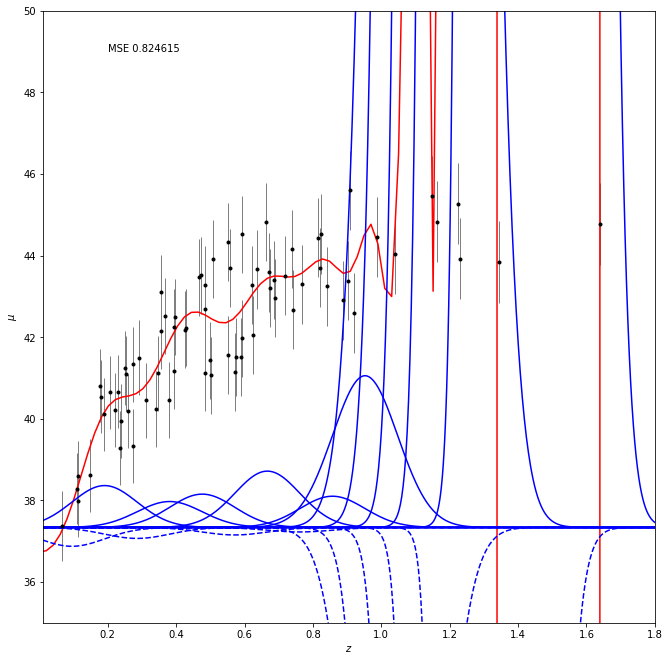

In [5]:
# Plot data and fit
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    hspace=0.05, wspace=0.05)
ax = fig.add_subplot(111)
ax.set_xlim(0.01, 1.8)
ax.set_ylim(35., 50.)


ax.errorbar(z_train,  mu_train[:,0],  mu_train[:,1], fmt='.k', ecolor='gray', lw=1)
z_fit = np.linspace(0,2,100)
mu_fit = clf.predict(z_fit[:, None])
ax.plot(z_fit, mu_fit, '-k',color='red')

ax.set_ylabel(r'$\mu$')
ax.set_xlabel(r'$z$')

err = np.sqrt(np.sum(((mu_sample_fit - mu_train[:,0])** 2) / (len(mu_sample_fit))))
ax.text(0.2, 49, "MSE {:f}".format(err))
#plot the gaussians
for i in range(nGaussian):
    if (clf.coef_[i+1] > 0.):
        ax.plot(z,clf.coef_[i+1]*gaussian_basis(z, basis_mu[i], basis_sigma) + clf.coef_[0],color='blue')
    else:
        ax.plot(z,clf.coef_[i+1]*gaussian_basis(z, basis_mu[i], basis_sigma) + clf.coef_[0],color='blue',ls='--')

## Exercise: How many Gaussians is the right number for the fit?

## Cross-validation
As the complexity of a model increases the data points fit the model more and more closely.

This does not result in a better fit to the data. We are overfitting the data (the model has high variance - a small change in a training point can change the model dramatically). This is a classic bias variance trade-off

We can evaluate this using a training set (50-70% of sample), a cross-validation set (15-25%) and a test set (15-25%)

The cross-validation set evaluates the cross-validation error $\epsilon_{\rm cv}$ of the model (large for overfit models). 

Test set gives an estimate of the reliability of the model.

We can define a cross validation error
$\epsilon_{\rm cv}^{(n)} = \sqrt{\frac{1}{n}\sum_{i=1}^{N_{\rm cv}}
  \left[y_i - \sum_{m=0}^d \theta_0^{(n)}x_i^m\right]^2}$

where we train on the first $n$ points ($\le N_{\rm train}$) and evaluate the error on the $N_{\rm cv}$ cross validation points.

In [6]:
# Plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    hspace=0.05, wspace=0.05)
ax = fig.add_subplot(111)

step = 1
nGaussians = np.arange(2, 10, step)
training_err = np.zeros(nGaussians.shape)
crossval_err = np.zeros(nGaussians.shape)
DOF_err = np.zeros(nGaussians.shape)

for i,j in enumerate(nGaussians):
    # fit the data
    basis_mu = np.linspace(0, 2, j)[:, None]
    basis_sigma = 3 * (basis_mu[1] - basis_mu[0])
    clf = BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma)
    n_constraints = len(basis_mu) + 1

    clf.fit(z_train[:, None], mu_train[:,0], mu_train[:,1])

    mu_train_fit = clf.predict(z_train[:, None])
    training_err[i] = np.sqrt(np.sum(((mu_train_fit - mu_train[:,0])) ** 2) / len(mu_train[:,0]))
    DOF_err[i] = np.sqrt(np.sum(((mu_train_fit - mu_train[:,0])) ** 2) / (len(mu_train[:,0]) - n_constraints))

    mu_test_fit = clf.predict(z_test[:, None])
    crossval_err[i] = np.sqrt(np.sum(((mu_test_fit - mu_test[:,0]))**2) / len(mu_test[:,0]))


ax.plot(nGaussians, crossval_err, '--k', label='cross-validation')
ax.plot(nGaussians, training_err, '-k', label='training')

ax.set_xlabel('Number of Gaussians')
ax.set_ylabel('rms error')
ax.legend(loc=2)
ax.set_xlim(0, nGaussians[-1])

plt.show()

### Penalized likelihoods

Bayes Information Criterion (BIC) 

$         {\rm BIC} \equiv -2 \ln\left[L^0(M)\right] + k \, \ln N $


Aikake information criterion (AIC)

${\rm AIC} \equiv  -2 \ln\left(L^0(M)\right) + 2\,k +  { 2k\,(k+1)  \over N - k -1}$


$L^0(M)$ : maximum value of the data likelihood

For complex models BIC penalizes more heavily than AIC

##  Regularization <a id='regularization'></a>
[Go to top](#toc)

If we progressively increase the number of terms in the fit we reach a regime where we are overfitting the data (i.e. there are not enough degrees of freedom)

For cases where we are concerned with overfitting we can apply constraints (usually of smoothness, number of coefficients, size of coefficients).

> ($Y - M \theta)^T(Y- M \theta) + \lambda |\theta^T \theta|$

with $\lambda$ the regularization parameter

This leads to a solution for the parameters of the model

> $\theta = (M^T C^{-1} M + \lambda I)^{-1} (M^T C^{-1} Y)$

with $I$ the identity model

From the Bayesian perspective this is the same as applying a prior to the regression coefficients

> $p(\theta | I ) \propto \exp{\left(\frac{-(\lambda \theta^T \theta)}{2}\right)}$

which, when multiplied by the likelihood for regression, gives the same posterior as described above

### Ridge (Tikhonov) regularization

> $ |\theta |^2 < s$

penalty is on the sum of the squares of the regression coefficients

<center><img width=50%,  src="figures/ridge.png"></center>

This penalizes the size of the coefficients


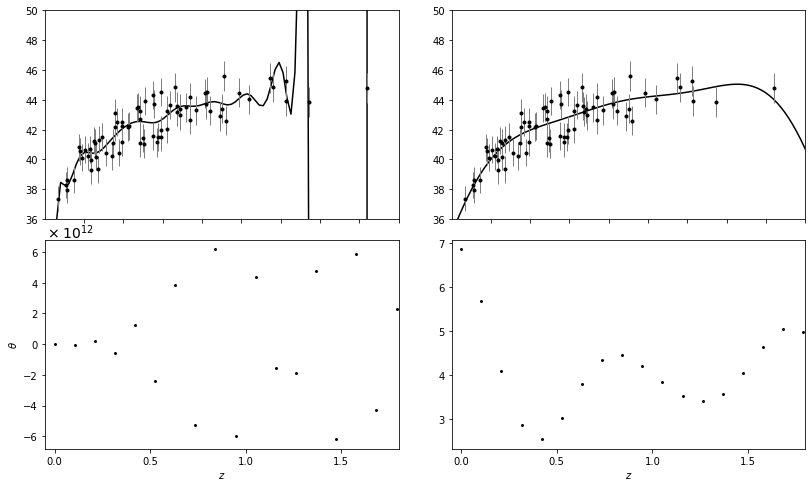

In [7]:
nGaussians=20
basis_mu = np.linspace(0, 2, nGaussians)
basis_sigma = 3 * (basis_mu[1] - basis_mu[0])
 
#------------------------------------------------------------
# Set up the figure to plot the results
fig = plt.figure(figsize=(12, 7))
fig.subplots_adjust(left=0.07, right=0.95,
                    bottom=0.08, top=0.95,
                    hspace=0.1, wspace=0.15)


def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

lamVal=0.09
z_fit = np.linspace(0., 2., 100)
regularization = ['none', 'l2',]
kwargs = [dict(), dict(alpha=lamVal),]

X = gaussian_basis(z_train[:, np.newaxis], basis_mu, basis_sigma)

for i in range(2):
    clf = LinearRegression(regularization=regularization[i],
                           fit_intercept=True, kwds=kwargs[i])
    clf.fit(X, mu_train[:,0], mu_train[:,1])
    w = clf.coef_
    mu_fit = clf.predict(gaussian_basis(z_fit[:, None], basis_mu, basis_sigma))


    # plot fit
    ax = fig.add_subplot(221 + i)
    ax.xaxis.set_major_formatter(plt.NullFormatter())

    ax.plot(z_fit, mu_fit, 'k')
    ax.errorbar(z_train,  mu_train[:,0], mu_train[:,1], fmt='.k', ecolor='gray', lw=1)
    ax.set_xlim(0.001, 1.8)
    ax.set_ylim(36, 50)
    
    # plot weights
    ax = fig.add_subplot(223 + i)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.set_xlabel('$z$')
    if i == 0:
        ax.set_ylabel(r'$\theta$')
        w *= 1E-12
        ax.text(0, 1.01, r'$\rm \times 10^{12}$',
                transform=ax.transAxes, fontsize=14)
    ax.scatter(basis_mu, w[1:], s=9, lw=0, c='k')

    ax.set_xlim(-0.05, 1.8)

### $\lambda$ is the amount of regularization. How do we choose $\lambda$ 

### Least absolute shrinkage and selection (Lasso) regularization

>$(Y - M \theta)^T(Y- M \theta) + \lambda |\theta|$


>$ |\theta | < s$

penalty is on the absolute values of the regression coefficients

<center><img src="figures/lasso.png"></center>

### QUESTION: What is the result of Lasso? What will happen to the regression coefficients

In [36]:
nGaussians=50
basis_mu = np.linspace(0, 2, nGaussians)
basis_sigma = 3 * (basis_mu[1] - basis_mu[0])
 
#------------------------------------------------------------
# Set up the figure to plot the results
fig = plt.figure(figsize=(12, 7))
fig.subplots_adjust(left=0.07, right=0.95,
                    bottom=0.08, top=0.95,
                    hspace=0.1, wspace=0.15)


def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

lamVal=0.0009
z_fit = np.linspace(0., 2., 100)
regularization = ['none', 'l1',]
kwargs = [dict(), dict(alpha=lamVal),]

X = gaussian_basis(z_train[:, np.newaxis], basis_mu, basis_sigma)

for i in range(2):
    clf = LinearRegression(regularization=regularization[i],
                           fit_intercept=True, kwds=kwargs[i])
    clf.fit(X, mu_train[:,0], mu_train[:,1])
    w = clf.coef_
    mu_fit = clf.predict(gaussian_basis(z_fit[:, None], basis_mu, basis_sigma))


    # plot fit
    ax = fig.add_subplot(221 + i)
    ax.xaxis.set_major_formatter(plt.NullFormatter())

    ax.plot(z_fit, mu_fit, 'k')
    ax.errorbar(z_train,  mu_train[:,0], mu_train[:,1], fmt='.k', ecolor='gray', lw=1)
    ax.set_xlim(0.001, 1.8)
    ax.set_ylim(36, 50)
    
    # plot weights
    ax = fig.add_subplot(223 + i)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.set_xlabel('$z$')
    if i == 0:
        ax.set_ylabel(r'$\theta$')
        w *= 1E-12
        ax.text(0, 1.01, r'$\rm \times 10^{12}$',
                transform=ax.transAxes, fontsize=14)
    ax.scatter(basis_mu, w[1:], s=9, lw=0, c='k')

    ax.set_xlim(-0.05, 1.8)
    

##  Non-linear Regression with MCMC<a id='mcmc'></a>
[Go to top](#toc)

### Here MCMC stands for Markov Chain Monte Carlo

In statistics, Markov chain Monte Carlo (MCMC) methods comprise a class of algorithms for sampling from a probability distribution. By constructing a Markov chain that has the desired distribution as its equilibrium distribution, one can obtain a sample of the desired distribution by recording states from the chain. The more steps are included, the more closely the distribution of the sample matches the actual desired distribution. Various algorithms exist for constructing chains, including the Metropolis–Hastings algorithm. For more details,
see Chapter 5 in the textbook and 
https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo


##### Highly recommended supplemental background reading:
- [Thomas Wiecki: ``MCMC sampling for dummies by Thomas Wiecki"](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/)
  
##### For those who want to dive deep:
- [Andrieu et al. ``An Introduction to MCMC for Machine Learning" (includes a few pages of history)"](http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf)

**To find the maximum of a multi-dimensional function (e.g. likelihood or Bayesian posterior pdf)
we need a better method than the brute force grid search!**

For example, if we could generate a **sample** of  {𝜇𝑖,𝜎𝑖}  drawn from the posterior pdf for  𝜇  and  𝜎 , we could simply get posterior pdf for  𝜇  and  𝜎  by plotting histograms of  𝜇  and  𝜎  (similar to the above figure). As simple as that!

First we'll say a few words about Monte Carlo in general, and then we'll talk about a special kind of Monte Carlo called Markov Chain Monte Carlo.

### Definition of the general problem

What we want to be able to do is to evaluate multi-dimensional 
($\theta$ is a k-dimensional vector) integrals of the form 
$$ I = \int g(\theta) \, p(\theta) \, d\theta,$$
where for simplicity posterior pdf is described as
$$ p(\theta) \equiv p(M,\theta \,|\,D,I) \propto p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I). $$

For example:

1) **Marginalization**: if the first $P$ elements of $\theta$ are the sought
after model parameters, and the next $k-P$ parameters are nuisance 
parameters, when marginalizing $p(\theta)$ over nuisance parameters
we have $g(\theta) = 1$ and we integrate over space spanned by $k-P$ 
nuisance parameters. 

2) **Point estimates** for the posterior: if we want the mean of a model
parameter $\theta_m$, then $g(\theta) = \theta_m$ and we integrate over
all model parameters. 

3) **Model comparison**: here $g(\theta) = 1$ and we integrate over all model
parameters. 

## Monte Carlo Methods 

What you need is a computer that can generate (pseudo)random numbers and then you
solve a lot of hard problems. Let' start with an easy problem of one-dimensional
numerical integration.

Assume that you can generate a distribution of M random numbers $\theta_j$ uniformly sampled 
within the integration volume V. Then our interval can be evaluated as 
$$ I = \int g(\theta) \, p(\theta) \, d\theta = \frac{V}{M} \sum_{j=1}^M g(\theta_j) \, p(\theta_j).$$
    
Note that in 1-D we can write a similar expression 
$$ I = \int f(\theta) \, d\theta = \Delta \, \sum_{j=1}^M g(\theta_j) \, p(\theta_j).$$

where $ f(\theta) = g(\theta) \, p(\theta) $, and it is assumed that the values
$\theta_j$ are sampled on a regular grid with the step $\Delta = V/M$ ($V$ here is the
length of the sampling domain). This expression is the simplest example of
numerical integration ("rectangle rule", which amounts to approximating $f(\theta)$
by a piecewise constant function).

The reason why we expressed $f(\theta)$
as a product of $g(\theta)$ and $p(\theta)$ is that, as we will see shortly,
we can generate a sample drawn from $p(\theta)$ (instead of sampling on a 
regular grid), and this greatly improves the performance of numerical integration.

##  Markov Chain Monte Carlo

The modern version of the Markov Chain Monte Carlo method was invented in the late 1940s by Stanislaw Ulam, while he was working on nuclear weapons projects at the Los Alamos National Laboratory. The name Monte Carlo
was given to the method by Nick Metropolis, who then invented the Metropolis sampler, which evolved into
one of the most famous MCMC algorithms, the Metropolis-Hastings algorithm. 

Algorithms for generating Markov chains are numerous and greatly vary in complexity
and applicability. Many of the most important ideas were generated in physics, especially
in the context of statistical mechanics, thermodynamics, and quantum field theory.


### Example of non-linear regression: the age-color relation for asteroids

We will use age and color data for asteroid families shown in figure 1 from the paper "An age–colour relationship for main-belt S-complex asteroids" by Jedicke et al. (2004, Nature 429, 275), see [jedicke.pdf](data/jedicke.pdf)

Given their y(x) data (see below), with errors in both x and y, we want to fit the following function

$$ 𝑦(𝑥)=𝑎+𝑏∗[1−𝑒𝑥𝑝(−(𝑥/𝑐)^𝑑)]. $$

We have a case of non-linear regression because y(x) depends non-linearly on the 
unknown coefficients c and d.
 
Important: here x is time, not log(time)! But in plots we'll use log(time) for x axis.

We want to: 

a) find the best-fit values and standard errors for parameters a, b, c and d. 

b) show the marginal distributions of fitted parameters. 

c) compare our best fit to the best fit from Jedicke et al.  


In [9]:
# These age and color data for asteroid families are taken
# from the paper Jedicke et al. (2004, Nature 429, 275) 

# Age is measured in 10^6 yrs (Myr)
# Log10(age) and error (of Log(Age))
logAge = np.asarray([3.398, 2.477, 3.398, 3.477, 3.301, 1.699, 2.699, 0.763,
         2.301, 3.079,  3.176, 0.398])
LageErr = np.asarray([0.087, 0.145, 0.174, 0.145, 0.109, 0.347, 0.174, 0.015,
          0.217, 0.145, 0.145, 0.434])
# SDSS principal asteroid color PC1 and its error (per family)
PC1 = np.asarray([0.620, 0.476, 0.523, 0.582, 0.460, 0.479, 0.432, 0.351, 
       0.427, 0.522, 0.532, 0.311])
PC1err = np.asarray([0.005, 0.015, 0.007, 0.011, 0.005, 0.032, 0.033, 0.047,
        0.021, 0.015, 0.022, 0.027])
# time/age on linear axes
age = 10**logAge
# and standard error propagation (although errors can be large)
ageErr = age * LageErr * np.log(10)

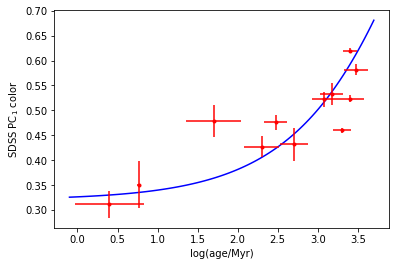

In [10]:
# let's take a quick look at the data to verify that it looks
# similar to fig. 1 from Jedicke et al. 
logT = np.linspace(-0.1, 3.7, 100)
time = np.power(10,logT)
# the best fit from Jedicke et al. 
color = 0.32 + 1.0*(1-np.exp(-(time/2.5e4)**0.5))
ax = plt.figure().add_subplot(111)
ax.set_xlabel("log(age/Myr)")
ax.set_ylabel("SDSS PC$_1$ color")
ax.plot(logT,color, c='blue')
ax.errorbar(logAge,PC1,xerr=LageErr, yerr=PC1err, color='r', 
             marker='.', ls='None', label='Observed')
plt.show() 

#### We will use pymc3 as the tool of choice to perform MCMC, see
[pymc3 docs](https://docs.pymc.io/)


I highly recommend to peruse this 
[excellent blog post by Jake VanderPlas](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)


In [12]:
import pymc3 as pm
from astroML.plotting.mcmc import plot_mcmc 

In [ ]:
# to make it look more generic (for future code reuse)
xObs = age
xErr = ageErr
yObs = PC1
yErr = PC1err

In [ ]:
# three points to make:
# 1) note setting of the priors (for a, b, c and d)
# 2) note how error in x is handled with a latent variable
# 3) the actual model that is fit is given by AgeColor()
#      and it's super easy to change it! 
def MCMCasteroids(doXerror=True, draws=10000, tune=1000):
    with pm.Model():
        a = pm.Uniform('a', 0.1, 0.5)
        b = pm.Uniform('b', 0, 10)
        c = pm.Uniform('c', 0, 2000000)
        d = pm.Uniform('d', 0, 2)

        if doXerror:
            xLatent = pm.Normal('x', mu=xObs, sd=xErr, shape=xObs.shape)  
        else:
            xLatent = xObs
 
        y = pm.Normal('y', mu=AgeColor(xLatent, a, b, c, d), sd=yErr, observed=yObs)
        traces = pm.sample(draws=draws, tune=tune, return_inferencedata=False)

        return traces
    
# model to fit 
def AgeColor(t, a, b, c, d):
    """age-color relationship from Jedicke et al. (2004)"""
    return a + b*(1-np.exp(-(t/c)**d))

In [ ]:
# obtain best-fit parameters using MCMC
traces = MCMCasteroids(True)
bf = pm.summary(traces)['mean']

In [ ]:
# let's take a look at the data and best-fit models 
logT = np.linspace(-0.1, 3.55, 100)
time = np.power(10,logT)

# fit from Jedicke
colorJedicke = 0.32 + 1.0*(1-np.exp(-(time/2.5e4)**0.5))
colorHere = AgeColor(time, bf['a'], bf['b'], bf['c'], bf['d']) 

# plot 
ax = plt.figure().add_subplot(111)
ax.set_xlabel("log(age/Myr)")
ax.set_ylabel("SDSS PC$_1$ color")
ax.plot(logT,colorJedicke, c='blue', label='best fit from Jedicke et al.')
ax.plot(logT,colorHere, c='green', label='best fit here')
ax.errorbar(logAge,PC1,xerr=LageErr, yerr=PC1err, color='r', marker='.', ls='None', label='data')
plt.legend()
plt.show() 

In [ ]:
# the so-called traces for model parameters:
plot = pm.traceplot(traces)

In [ ]:
# and a pretty so-called corner plot:
labels = ['$a$', '$b$', '$c$', '$d$']
limits = [(0.1, 0.55), (0.0, 12), (-100000,2200000), (0.1, 0.85)]
jedicke = [0.32, 1.0, 25000, 0.5]


# Plot the results
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([traces[i] for i in ['a', 'b', 'c', 'd']],
          labels=labels, limits=limits,
          true_values=jedicke, fig=fig, bins=30, colors='k')

plt.show()

In [26]:
import corner

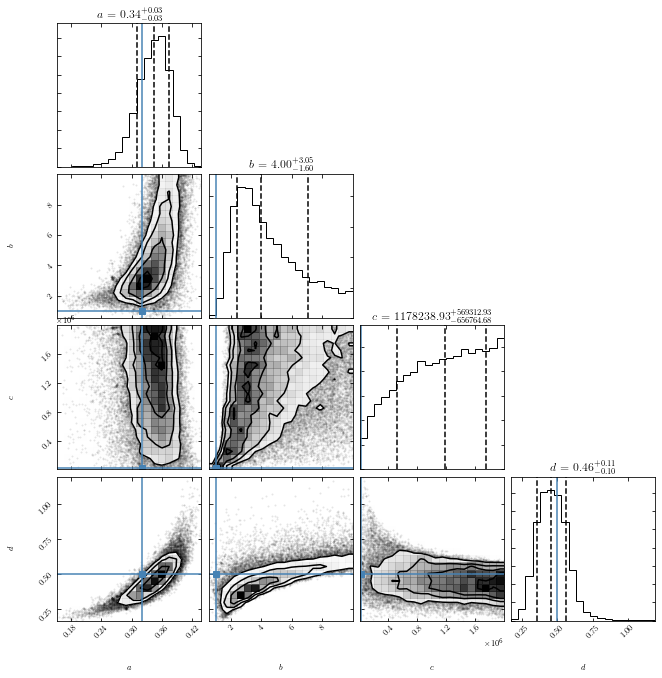

In [27]:
Ls = [r"$a$", r"$b$", r"$c$", r"$d$"] 
samples = np.vstack([traces[i] for i in ['a', 'b', 'c', 'd']]).T
corner.corner(samples, truths=jedicke, labels=Ls, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12});